# Alternative OpenAPS Activity and IOB Calculations
----
The code in this notebook will produce `Activity` and `IOB` values that are explicitly tied to eachother and do not rely on exogenous coefficient estimates as currently done in the OpenAPS code (`OpenAPS/oref0/lib/iob/calculation.js`)

Some Definitions:
* `dia` : Duration of Insulin Activity. This is the user specified time (in hours) that insulin lasts in their body after a bolus. Default setting used in OpenAPS is 3 (hours). This value comes from the user's pump settings. [Not sure what limits Medtronic places on setting this. Testing here assumes integers between 2 and 8 hours.]


* `end` : Duration (in minutes) that insulin is active. `end` = `dia` * 60.


* `peak` : Duration (in minutes) when insulin action it's peak activity level. 

  **Key Assumption:** Given a default value of 3 hours for `dia`, which translates into 180 minutes for `end`, assume that peak insulin activity ocurrs between 60 and 90 minutes after dosage. As such, the OpenAPS algorithm assumes a `peak` of 75 minutes for a `dia` of 3 hours. This assumption is generalizable to other user `dia` settings. That is, `peak` can be expressed as a function of `dia`:
  
  `peak` = f(`dia`) = (`dia` \* 60 \* (75 / 180)).


* `Activity` : This is the variable name used in OpenAPS to represent "units of insulin that was active in the previous minute." 

  `OpenAPS/oref0/lib/iob/calculation.js`calculates a variable `activityContrib` that is equal to the product of `treatment.insulin` and a slope equal to: `2 / dia / 60 / peak`, which is then multiplied by the `minAgo` variable, which is how long it's been since the `treatment.insulin` value was delivered.
  
  
* `IOB` : Insulin on Board. The variable `iob` in OpenAPS means something other than what most think of as IOB.
  
  In OpenAPS, `iob` represents *total insulin on board, **relative to pre-programmed user basal rate insulin.** It is therefore, often referred to as "net iob" -- it can be negative when OpenAPS has issued a low-temp basal rate (that is, a basal rate that is less than the user's pre-programmed basal rate).

Results from the algorithm will be plotted to check that insulin activity and IOB calculations are working correctly.
and plot the Activity curves for a set of Duration of Insulin Activity (dia) values.



In [32]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
def calc_activity_and_iob(dia):
    
    end = dia * 60.0
    peak = end * (75.0 / 180.0) # 75 and 180 are peak and end parameters based on a dia = 3 hours. 75 / 180 = 0.416667
    
    print (end, peak)
    
    activity_list = []
    iob_list = []
    
    insulin_used_1 = (peak / end)          # portion of insulin used up to peak (42.6667%)
    insulin_used_2 = ((end - peak) / end)  # portion of insulin used from peak to end (58.3333%)
    
    slope_1 =  insulin_used_1 / (peak / 2.0) / (peak + 1.0)                # insulin activity slope from minute [0, peak]
    slope_2 =  insulin_used_2 / ((end - peak) / 2.0) / (end - peak + 1.0)  # insulin activity slope from minute (peak, end]
    
    print(slope_1, slope_2)
    
    for i_min in range(0, int(end) + 1):
        
        if (i_min <= peak):
            activity = slope_1 * i_min
            cummulative_minutes = (i_min * (i_min + 1)) / 2
            iob = 1 - (slope_1 * cummulative_minutes)
        
        elif (i_min <= end):
            activity = slope_2 * (end - i_min + 1)
            cummulative_minutes = ((end - i_min) * (end - i_min + 1)) / 2
            iob = slope_2 * cummulative_minutes

        activity_list.append(activity)
        iob_list.append(iob)    
            
    return activity_list, iob_list

In [81]:
calc_activity_and_iob(3)

(180.0, 75.0)
(0.00014619883040935673, 0.00010482180293501049)


([0.0,
  0.00014619883040935673,
  0.00029239766081871346,
  0.0004385964912280702,
  0.0005847953216374269,
  0.0007309941520467836,
  0.0008771929824561404,
  0.0010233918128654971,
  0.0011695906432748538,
  0.0013157894736842105,
  0.0014619883040935672,
  0.001608187134502924,
  0.0017543859649122807,
  0.0019005847953216374,
  0.0020467836257309943,
  0.0021929824561403508,
  0.0023391812865497076,
  0.0024853801169590645,
  0.002631578947368421,
  0.002777777777777778,
  0.0029239766081871343,
  0.0030701754385964912,
  0.003216374269005848,
  0.0033625730994152046,
  0.0035087719298245615,
  0.0036549707602339184,
  0.003801169590643275,
  0.003947368421052632,
  0.004093567251461989,
  0.0042397660818713455,
  0.0043859649122807015,
  0.004532163742690058,
  0.004678362573099415,
  0.004824561403508772,
  0.004970760233918129,
  0.005116959064327485,
  0.005263157894736842,
  0.005409356725146199,
  0.005555555555555556,
  0.005701754385964913,
  0.005847953216374269,
  0.0059

In [79]:
# Create a dictionary of DataFrames -- one for each value of DIA between 2 and 8
dict_of_dfs_by_dia = {}

for dia in range(2, 9):                           # Note: range() ends at n-1
    
    activity_list, iob_list = cal_activity_and_iob(dia)
    
    activity_df = pd.DataFrame({'activity_dia_' + str(dia) : calc_activity_and_iob(dia)[1], 
                                'iob_dia_' + str(dia) : calc_activity_and_iob(dia)[2]})
    
    # Add a cummulative sum column for activity
    activity_df['cum_activity_dia_' + str(dia)] = activity_df['activity_dia_' + str(dia)].cumsum()
   
    # Put df into a dictionary with dia as the key
    dict_of_dfs_by_dia.update({dia : activity_df})

NameError: name 'cal_activity_and_iob' is not defined

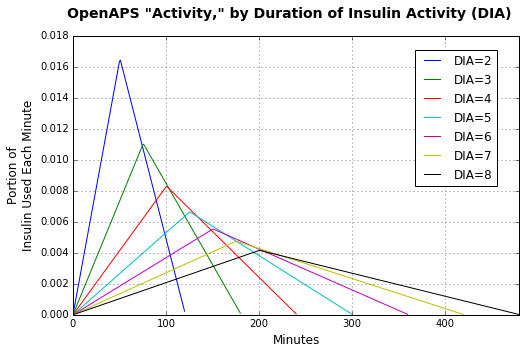

In [75]:
# Now plot the curves
plt.figure(figsize=(8, 5))
#plt.axis([0,480,0,1])
plt.ylabel('Portion of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS "Activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for dia in range(2,9):
    dia_str = str(dia)
    dict_of_dfs_by_dia[dia]['activity_dia_' + dia_str].plot(kind='line', label='DIA='+dia_str).grid(True)

plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)
plt.savefig('Alt_OpenAPS_activity_by_dia.png', format='png', dpi=600)
plt.show()  

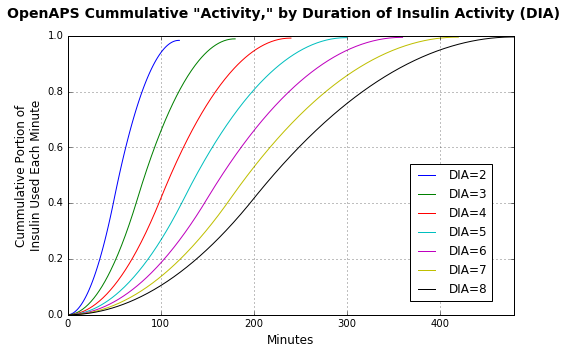

In [37]:
# Now plot the cummulative activity curves
plt.figure(figsize=(8, 5))
plt.ylabel('Cummulative Portion of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Cummulative "Activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for dia in range(2,9):
    dia_str = str(dia)
    dict_of_dfs_by_dia[dia]['cum_activity_dia_' + dia_str].plot(kind='line', label='DIA='+dia_str).grid(True)

plt.legend(bbox_to_anchor=(0.95, 0.05), loc=4, borderaxespad=0.)
plt.savefig('Alt_OpenAPS_cum_activity_by_dia.png', format='png', dpi=600)
plt.show()  

In [38]:
dict_of_dfs_by_dia[3].head()

,activity_dia_3,iob_dia_3,cum_activity_dia_3
0,0.000000,1.000000,0.000000
1,0.000146,0.999854,0.000146
2,0.000292,0.999561,0.000439
3,0.000439,0.999123,0.000877
4,0.000585,0.998538,0.001462


In [39]:
dict_of_dfs_by_dia[3].tail()

,activity_dia_3,iob_dia_3,cum_activity_dia_3
176,0.000419,0.001048,0.988365
177,0.000314,0.000629,0.988679
178,0.000210,0.000314,0.988889
179,0.000105,0.000105,0.988994
180,0.000000,0.000000,0.988994
